### Decision Trees using Gini Impurity and Cross entropy impurity


In [1]:
import numpy as np

In [2]:
data = np.genfromtxt('PCA_MNIST.csv', delimiter=',')
labels = data[1:, 0]
data = data[1:, 1:]
print(labels.shape, data.shape)

(60000,) (60000, 10)


Standardizing the inputs
    You should also standardize the test data also or else it leads to the suboptimal performance.
    The above scenario introduces the bias because the models internal decision boundaries and the weights are in the scaled version.
    It also leads to the Inaccuracy, because there may be some features with high range in their values which is not fair.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [4]:
print(len(X_train), len(X_test))

48000 12000


In [5]:
from sklearn.utils import resample

# Separate the training data by class
X_by_class = []
y_by_class = []
for class_label in np.unique(y_train):
    X_by_class.append(X_train[y_train == class_label])
    y_by_class.append(y_train[y_train == class_label])

# X_by_class --> (4823,10) * 10classes
# y_by_class --> (4823,1) * 10classes

# Downsample each class to have the same number of samples
sample_count = 2000 // len(np.unique(y_train))
X_resampled = []
y_resampled = []
for i in range(len(X_by_class)):
    X_resampled_class, y_resampled_class = resample(X_by_class[i], y_by_class[i], replace=False, n_samples=sample_count)
    X_resampled.append(X_resampled_class)
    y_resampled.append(y_resampled_class)

# X_resampled --> (200,10) * 10classes
# y_resampled --> (200,1) * 10classes

# Combine the resampled training data into a single array
X_resampled = np.concatenate(X_resampled, axis=0)
y_resampled = np.concatenate(y_resampled, axis=0)

# X_resampled --> (2000,10)
# y_resampled --> (2000,1) 

# Shuffle the training data
shuffle_indices = np.random.permutation(len(X_resampled))
X_resampled = X_resampled[shuffle_indices]
y_resampled = y_resampled[shuffle_indices]

X_train_resampled = np.array(X_resampled)
y_train_resampled = np.array(y_resampled)

data_resampled = np.concatenate((X_train_resampled, y_train_resampled.reshape(-1, 1)), axis=1)   #data_resampled --> (2000,11)
np.savetxt('PCA_MNIST_train_resampled.csv', data_resampled, delimiter=',')

In [6]:
from sklearn.utils import resample

# Separate the test data by class
X_by_class = []
y_by_class = []
for class_label in np.unique(y_test):
    X_by_class.append(X_test[y_test == class_label])
    y_by_class.append(y_test[y_test == class_label])

# Downsample each class to have the same number of samples
sample_count = 2000 // len(np.unique(y_test))
X_resampled = []
y_resampled = []
for i in range(len(X_by_class)):
    X_resampled_class, y_resampled_class = resample(X_by_class[i], y_by_class[i], replace=False, n_samples=sample_count)
    X_resampled.append(X_resampled_class)
    y_resampled.append(y_resampled_class)

# Combine the resampled test data into a single array
X_resampled = np.concatenate(X_resampled, axis=0)
y_resampled = np.concatenate(y_resampled, axis=0)

# Shuffle the test data
shuffle_indices = np.random.permutation(len(X_resampled))
X_resampled = X_resampled[shuffle_indices]
y_resampled = y_resampled[shuffle_indices]

X_test_resampled = np.array(X_resampled)
y_test_resampled = np.array(y_resampled)

data_resampled = np.concatenate((X_test_resampled, y_test_resampled.reshape(-1, 1)), axis=1)
np.savetxt('PCA_MNIST_test_resampled.csv', data_resampled, delimiter=',')

#### Using Gini Index

cross_validation_split(dataset,n_folds)  
    -->returns a list of n_folds of fold_size each, by selecting randomly from the dataset copy each time.  
    -->fold_size = len(dataset // n_folds)  

accuracy_metric(actual, predicted)  
    -->calculates the accuracy for the given actual labels and the predicted labels.  

evaluate_algorithm(dataset, algorithm, n_folds, *args)  
    -->evaluates the algorithm by considering each fold as a test data each time and remaining folds as the train data, and getting the average accuracy result.  
    -->For this the test data labels are set to be None at the beginning and evaluated the algorithm.  

test_split(index, value, dataset)  
    -->The data is splitted to the left and right nodes by comparing the data[index] with value(threshold).  
    -->Returns the left node and right node.  
  
gini_index(groups, classes)  
    -->check out the image IMG_01.jpg to know how it calculates the gini index for each stump.  
    -->returns the gini impurity value.  

get_split(dataset)  
    -->It returns the best feature based on which the dataset is splitted, best theshold value to compare while splitting and the groups correspondingly.  



    


In [7]:
from random import seed
from random import randrange
from csv import reader

def load_csv(filename):
    file = open(filename, "rt")
    lines = reader(file)
    dataset = list(lines)
    return dataset

def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        tree, predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return tree, scores

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = np.inf, np.inf, np.inf, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return (tree, predictions)

In [8]:
train_filename = 'PCA_MNIST_train_resampled.csv'
train_dataset = load_csv(train_filename)

In [9]:
test_filename = 'PCA_MNIST_test_resampled.csv'
test_dataset = load_csv(test_filename)

In [10]:
print(len(test_dataset[0]))

11


Scores: [36.0, 36.199999999999996]
Mean Accuracy: 36.100%


/home/isl/anaconda3/envs/SAI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


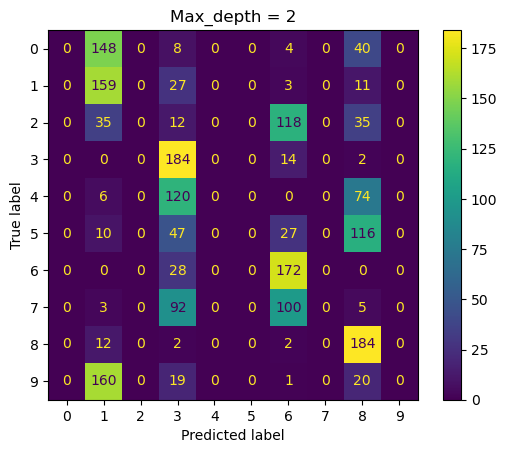

Scores: [55.300000000000004, 55.00000000000001]
Mean Accuracy: 55.150%


/home/isl/anaconda3/envs/SAI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


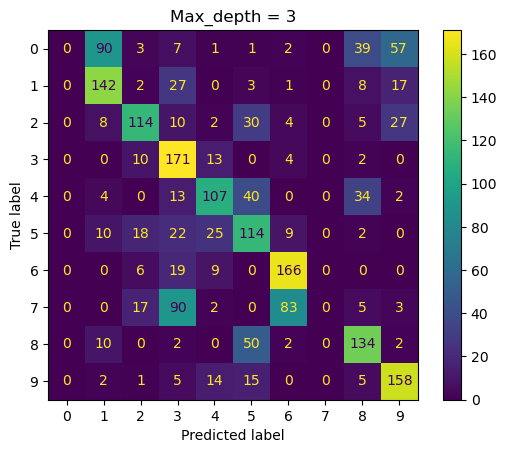

Scores: [69.8, 70.8]
Mean Accuracy: 70.300%


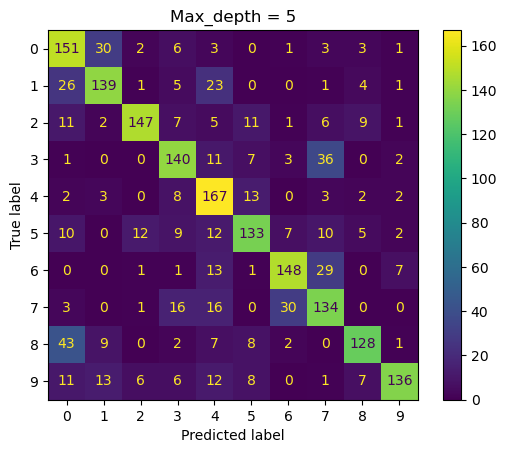

Scores: [71.0, 69.3]
Mean Accuracy: 70.150%


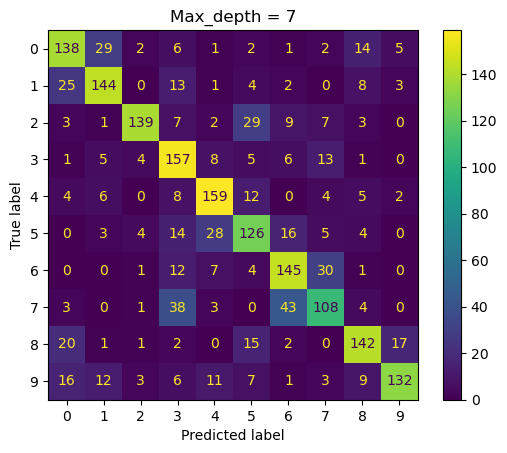

In [11]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay  
import matplotlib.pyplot as plt

n_folds = 2
max_depth = [2,3,5,7]
min_size = 10
accu_list, prec_list, recall_list, f1_list = [],[],[],[]
for depth in max_depth:
    tree, scores = evaluate_algorithm(train_dataset, decision_tree, n_folds, depth, min_size)

    print('Scores: %s' % scores)
    Mean_accuracy = sum(scores)/float(len(scores))
    print('Mean Accuracy: %.3f%%' % (Mean_accuracy))

    actual = [row[-1] for row in test_dataset]
    predictions = list()
    for row in test_dataset:
        prediction = predict(tree, row)
        predictions.append(prediction)

    score = accuracy_metric(actual,predictions)
    prec, rec, fscore, _ = precision_recall_fscore_support(actual, predictions, average='weighted')
    accu_list.append(score)
    prec_list.append(prec)
    recall_list.append(rec)
    f1_list.append(fscore)

    conf = confusion_matrix(actual, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    disp.plot()
    plt.title('Max_depth = ' + str(depth))
    plt.show()

In [12]:
accu_list = [acc/100 for acc in accu_list]

In [13]:
print(f'Accuracy_list: {accu_list}')
print(f'precision_list: {prec_list}')
print(f'recall_list: {recall_list}')
print(f'f1score_list: {f1_list}')


Accuracy_list: [0.3495, 0.553, 0.7115, 0.695]
precision_list: [0.14075304418155837, 0.45159850236058563, 0.7285531012839462, 0.7053663065410863]
recall_list: [0.3495, 0.553, 0.7115, 0.695]
f1score_list: [0.20041275570631067, 0.4905781734565525, 0.7140613513963254, 0.6958281648588017]


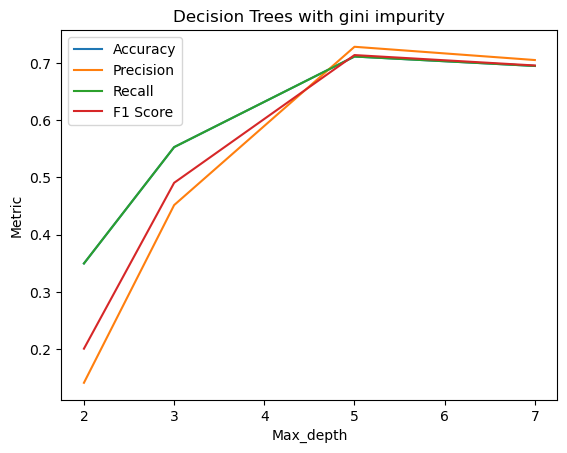

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(max_depth, accu_list)
plt.plot(max_depth, prec_list)
plt.plot(max_depth, recall_list)
plt.plot(max_depth, f1_list)
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.xlabel('Max_depth')
plt.ylabel('Metric')
plt.title('Decision Trees with gini impurity')
plt.show()

#### Using Cross Entropy

In [15]:
from random import seed
from random import randrange
from csv import reader
from math import log2

def load_csv(filename):
    file = open(filename, "rt")
    lines = reader(file)
    dataset = list(lines)
    return dataset

def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        tree, predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return tree, scores

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def ce_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    ce = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            if p == 0:
                continue
            score -= p * log2(p)
        ce += score * (size / n_instances)
    return ce

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = np.inf, np.inf, np.inf, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = ce_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(tree, predictions)

Scores: [36.0, 36.199999999999996]
Mean Accuracy: 36.100%


/home/isl/anaconda3/envs/SAI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


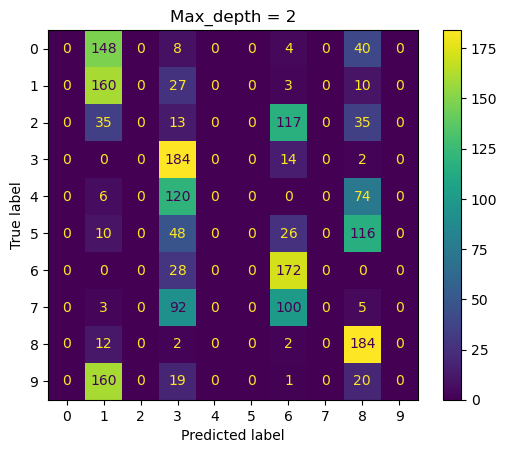

Scores: [53.2, 53.300000000000004]
Mean Accuracy: 53.250%


/home/isl/anaconda3/envs/SAI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


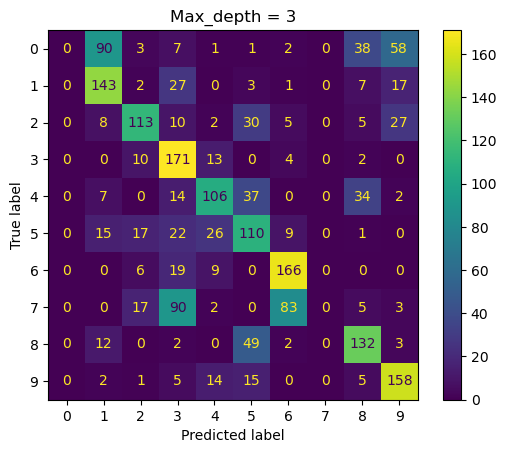

Scores: [68.5, 66.2]
Mean Accuracy: 67.350%


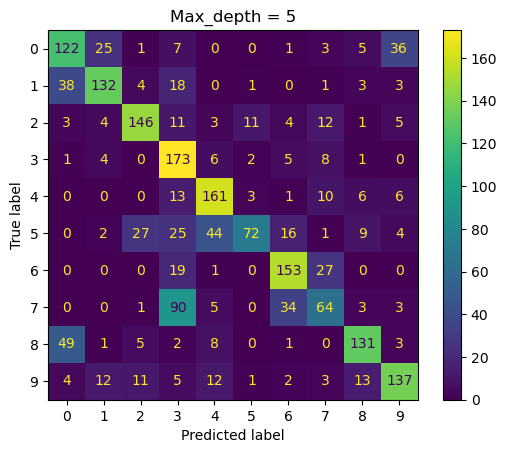

Scores: [68.0, 70.1]
Mean Accuracy: 69.050%


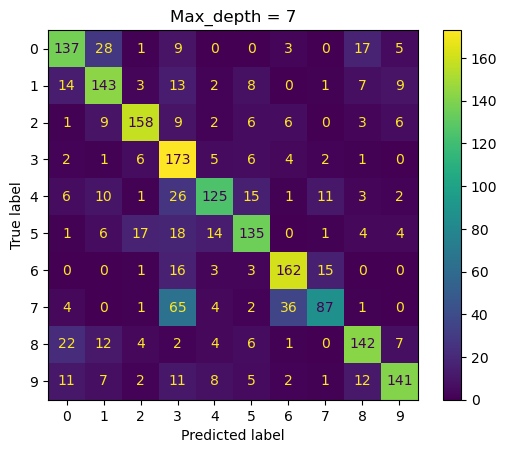

In [16]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay  
import matplotlib.pyplot as plt

n_folds = 2
max_depth = [2,3,5,7]
min_size = 10
accu_list, prec_list, recall_list, f1_list = [],[],[],[]
for depth in max_depth:
    tree, scores = evaluate_algorithm(train_dataset, decision_tree, n_folds, depth, min_size)

    print('Scores: %s' % scores)
    Mean_accuracy = sum(scores)/float(len(scores))
    print('Mean Accuracy: %.3f%%' % (Mean_accuracy))

    actual = [row[-1] for row in test_dataset]
    predictions = list()
    for row in test_dataset:
        prediction = predict(tree, row)
        predictions.append(prediction)

    score = accuracy_metric(actual,predictions)
    prec, rec, fscore, _ = precision_recall_fscore_support(actual, predictions, average='weighted')
    accu_list.append(score)
    prec_list.append(prec)
    recall_list.append(rec)
    f1_list.append(fscore)

    conf = confusion_matrix(actual, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    disp.plot()
    plt.title('Max_depth = ' + str(depth))
    plt.show()

In [17]:
accu_list = [acc/100 for acc in accu_list]

In [18]:
print(f'Accuracy_list: {accu_list}')
print(f'precision_list: {prec_list}')
print(f'recall_list: {recall_list}')
print(f'f1score_list: {f1_list}')


Accuracy_list: [0.35, 0.5495, 0.6455, 0.7015]
precision_list: [0.14101367413593252, 0.44887865203843147, 0.664993315347968, 0.7197036373813286]
recall_list: [0.35, 0.5495, 0.6455, 0.7015]
f1score_list: [0.20073777900365378, 0.4871956195462839, 0.6379392078223123, 0.7007138353317937]


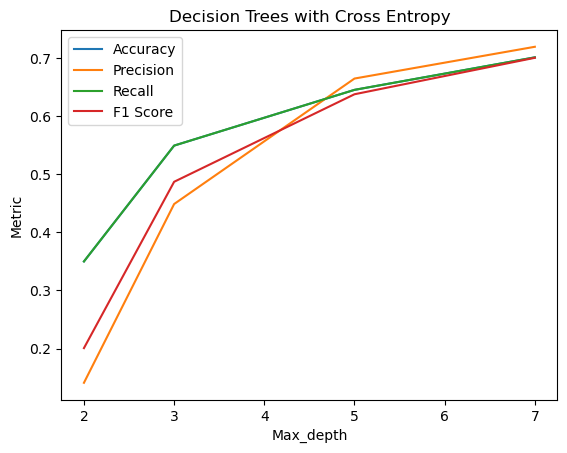

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(max_depth, accu_list)
plt.plot(max_depth, prec_list)
plt.plot(max_depth, recall_list)
plt.plot(max_depth, f1_list)
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.xlabel('Max_depth')
plt.ylabel('Metric')
plt.title('Decision Trees with Cross Entropy')
plt.show()

### Random Forests performed with varying number of trees.

In [20]:
import numpy as np
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# It gives the argmax of all the predicted classes in a particular tree.
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

#Sampling is done with Repitition, So, NO .pop() in while loop
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

# Returning the max of all the outputs of all the trees in a forest since it is a classification task.
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)

def random_forest(train, val, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)          # Here build tree() take cares of outputing only one prediction for the tree.
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in val]             # Here bagging_predict() take care of outputing the max prediction of all trees
    return(trees, predictions)                                                     # so for each instance one prediction.



def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    all_preds = []
    all_actuals = []

    # For each fold as a test test we are finding the predictions in which each prediction is the maximum of all trees in the forest.
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        val_set = list()
        for row in fold:
            row_copy = list(row)
            val_set.append(row_copy)
            row_copy[-1] = None
        trees, predicted = algorithm(train_set, val_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy) 
        all_preds.append(predicted)
        all_actuals.append(actual)
    print('Scores: %s' % scores)
    return trees, scores

In [21]:

filename = 'PCA_MNIST_test_resampled.csv'
test_dataset = load_csv(filename)
print(len(test_dataset[0]))


11


Trees: 1
Scores: [61.199999999999996, 56.00000000000001, 62.4, 62.4]
Mean Accuracy: 60.500%

actual: [3, 1, 8, 1, 1, 9, 2, 7, 2, 1, 4, 6, 6, 0, 9, 0, 0, 3, 5, 2, 5, 1, 4, 2, 0, 7, 4, 1, 0, 9, 3, 3, 3, 0, 8, 9, 8, 2, 5, 6, 3, 8, 6, 2, 4, 7, 9, 3, 2, 7, 4, 3, 1, 9, 5, 3, 3, 9, 6, 0, 3, 8, 7, 5, 6, 9, 6, 8, 6, 3, 6, 8, 1, 1, 7, 6, 3, 6, 4, 9, 4, 9, 8, 4, 1, 2, 3, 7, 9, 6, 5, 1, 7, 9, 3, 1, 9, 2, 7, 5, 2, 2, 1, 9, 7, 1, 1, 9, 0, 8, 6, 1, 8, 4, 5, 3, 0, 0, 7, 1, 7, 7, 9, 3, 5, 5, 3, 4, 1, 7, 7, 0, 6, 1, 2, 2, 1, 6, 4, 4, 5, 2, 6, 0, 5, 8, 9, 7, 9, 4, 3, 2, 5, 0, 9, 4, 5, 9, 2, 1, 1, 3, 6, 5, 3, 8, 9, 0, 7, 3, 2, 5, 6, 2, 0, 8, 3, 3, 6, 8, 0, 7, 8, 6, 7, 7, 0, 0, 8, 2, 3, 8, 2, 6, 2, 1, 8, 1, 6, 0, 9, 1, 4, 6, 0, 3, 8, 2, 8, 3, 6, 5, 5, 8, 5, 1, 3, 7, 7, 5, 8, 2, 1, 8, 6, 9, 2, 1, 7, 9, 3, 7, 3, 0, 5, 1, 0, 7, 8, 0, 8, 8, 1, 3, 7, 8, 2, 0, 9, 5, 9, 6, 5, 6, 3, 8, 7, 4, 0, 8, 2, 2, 7, 6, 7, 3, 4, 6, 6, 3, 2, 8, 5, 9, 5, 0, 4, 9, 1, 6, 9, 7, 9, 8, 7, 5, 9, 3, 1, 0, 9, 8, 4, 0, 8, 7, 7, 0, 2, 1

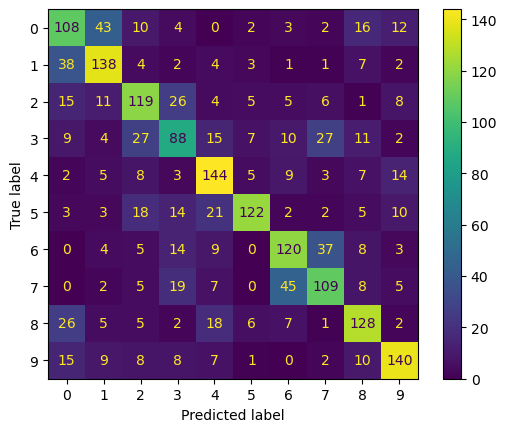

Trees: 3
Scores: [64.2, 63.0, 68.60000000000001, 64.4]
Mean Accuracy: 65.050%

actual: [3, 1, 8, 1, 1, 9, 2, 7, 2, 1, 4, 6, 6, 0, 9, 0, 0, 3, 5, 2, 5, 1, 4, 2, 0, 7, 4, 1, 0, 9, 3, 3, 3, 0, 8, 9, 8, 2, 5, 6, 3, 8, 6, 2, 4, 7, 9, 3, 2, 7, 4, 3, 1, 9, 5, 3, 3, 9, 6, 0, 3, 8, 7, 5, 6, 9, 6, 8, 6, 3, 6, 8, 1, 1, 7, 6, 3, 6, 4, 9, 4, 9, 8, 4, 1, 2, 3, 7, 9, 6, 5, 1, 7, 9, 3, 1, 9, 2, 7, 5, 2, 2, 1, 9, 7, 1, 1, 9, 0, 8, 6, 1, 8, 4, 5, 3, 0, 0, 7, 1, 7, 7, 9, 3, 5, 5, 3, 4, 1, 7, 7, 0, 6, 1, 2, 2, 1, 6, 4, 4, 5, 2, 6, 0, 5, 8, 9, 7, 9, 4, 3, 2, 5, 0, 9, 4, 5, 9, 2, 1, 1, 3, 6, 5, 3, 8, 9, 0, 7, 3, 2, 5, 6, 2, 0, 8, 3, 3, 6, 8, 0, 7, 8, 6, 7, 7, 0, 0, 8, 2, 3, 8, 2, 6, 2, 1, 8, 1, 6, 0, 9, 1, 4, 6, 0, 3, 8, 2, 8, 3, 6, 5, 5, 8, 5, 1, 3, 7, 7, 5, 8, 2, 1, 8, 6, 9, 2, 1, 7, 9, 3, 7, 3, 0, 5, 1, 0, 7, 8, 0, 8, 8, 1, 3, 7, 8, 2, 0, 9, 5, 9, 6, 5, 6, 3, 8, 7, 4, 0, 8, 2, 2, 7, 6, 7, 3, 4, 6, 6, 3, 2, 8, 5, 9, 5, 0, 4, 9, 1, 6, 9, 7, 9, 8, 7, 5, 9, 3, 1, 0, 9, 8, 4, 0, 8, 7, 7, 0, 2, 1, 9, 9, 7, 0, 

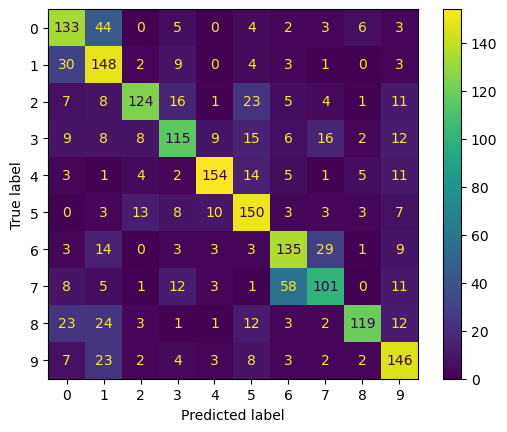

Trees: 5
Scores: [69.19999999999999, 71.6, 75.6, 67.80000000000001]
Mean Accuracy: 71.050%

actual: [3, 1, 8, 1, 1, 9, 2, 7, 2, 1, 4, 6, 6, 0, 9, 0, 0, 3, 5, 2, 5, 1, 4, 2, 0, 7, 4, 1, 0, 9, 3, 3, 3, 0, 8, 9, 8, 2, 5, 6, 3, 8, 6, 2, 4, 7, 9, 3, 2, 7, 4, 3, 1, 9, 5, 3, 3, 9, 6, 0, 3, 8, 7, 5, 6, 9, 6, 8, 6, 3, 6, 8, 1, 1, 7, 6, 3, 6, 4, 9, 4, 9, 8, 4, 1, 2, 3, 7, 9, 6, 5, 1, 7, 9, 3, 1, 9, 2, 7, 5, 2, 2, 1, 9, 7, 1, 1, 9, 0, 8, 6, 1, 8, 4, 5, 3, 0, 0, 7, 1, 7, 7, 9, 3, 5, 5, 3, 4, 1, 7, 7, 0, 6, 1, 2, 2, 1, 6, 4, 4, 5, 2, 6, 0, 5, 8, 9, 7, 9, 4, 3, 2, 5, 0, 9, 4, 5, 9, 2, 1, 1, 3, 6, 5, 3, 8, 9, 0, 7, 3, 2, 5, 6, 2, 0, 8, 3, 3, 6, 8, 0, 7, 8, 6, 7, 7, 0, 0, 8, 2, 3, 8, 2, 6, 2, 1, 8, 1, 6, 0, 9, 1, 4, 6, 0, 3, 8, 2, 8, 3, 6, 5, 5, 8, 5, 1, 3, 7, 7, 5, 8, 2, 1, 8, 6, 9, 2, 1, 7, 9, 3, 7, 3, 0, 5, 1, 0, 7, 8, 0, 8, 8, 1, 3, 7, 8, 2, 0, 9, 5, 9, 6, 5, 6, 3, 8, 7, 4, 0, 8, 2, 2, 7, 6, 7, 3, 4, 6, 6, 3, 2, 8, 5, 9, 5, 0, 4, 9, 1, 6, 9, 7, 9, 8, 7, 5, 9, 3, 1, 0, 9, 8, 4, 0, 8, 7, 7, 0, 2, 1,

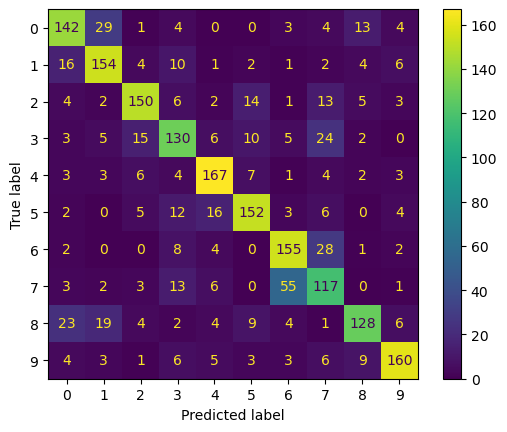

Trees: 7
Scores: [76.6, 73.8, 72.39999999999999, 72.6]
Mean Accuracy: 73.850%

actual: [3, 1, 8, 1, 1, 9, 2, 7, 2, 1, 4, 6, 6, 0, 9, 0, 0, 3, 5, 2, 5, 1, 4, 2, 0, 7, 4, 1, 0, 9, 3, 3, 3, 0, 8, 9, 8, 2, 5, 6, 3, 8, 6, 2, 4, 7, 9, 3, 2, 7, 4, 3, 1, 9, 5, 3, 3, 9, 6, 0, 3, 8, 7, 5, 6, 9, 6, 8, 6, 3, 6, 8, 1, 1, 7, 6, 3, 6, 4, 9, 4, 9, 8, 4, 1, 2, 3, 7, 9, 6, 5, 1, 7, 9, 3, 1, 9, 2, 7, 5, 2, 2, 1, 9, 7, 1, 1, 9, 0, 8, 6, 1, 8, 4, 5, 3, 0, 0, 7, 1, 7, 7, 9, 3, 5, 5, 3, 4, 1, 7, 7, 0, 6, 1, 2, 2, 1, 6, 4, 4, 5, 2, 6, 0, 5, 8, 9, 7, 9, 4, 3, 2, 5, 0, 9, 4, 5, 9, 2, 1, 1, 3, 6, 5, 3, 8, 9, 0, 7, 3, 2, 5, 6, 2, 0, 8, 3, 3, 6, 8, 0, 7, 8, 6, 7, 7, 0, 0, 8, 2, 3, 8, 2, 6, 2, 1, 8, 1, 6, 0, 9, 1, 4, 6, 0, 3, 8, 2, 8, 3, 6, 5, 5, 8, 5, 1, 3, 7, 7, 5, 8, 2, 1, 8, 6, 9, 2, 1, 7, 9, 3, 7, 3, 0, 5, 1, 0, 7, 8, 0, 8, 8, 1, 3, 7, 8, 2, 0, 9, 5, 9, 6, 5, 6, 3, 8, 7, 4, 0, 8, 2, 2, 7, 6, 7, 3, 4, 6, 6, 3, 2, 8, 5, 9, 5, 0, 4, 9, 1, 6, 9, 7, 9, 8, 7, 5, 9, 3, 1, 0, 9, 8, 4, 0, 8, 7, 7, 0, 2, 1, 9, 9, 7, 0, 

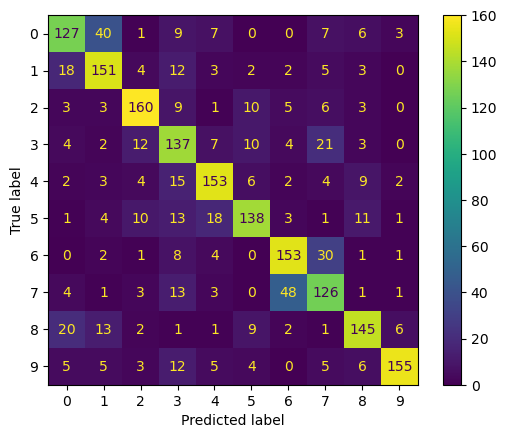

In [22]:
seed(2)

filename = 'PCA_MNIST_train_resampled.csv'
train_dataset = load_csv(filename)

filename = 'PCA_MNIST_test_resampled.csv'
test_dataset = load_csv(filename)

# evaluate algorithm
n_folds = 4
max_depth = 10
min_size = 1
sample_size = 0.7
num_trees = [1, 3, 5, 7]
n_features = int(sqrt(len(train_dataset[0])-1))
accu_list, prec_list, recall_list, f1_list = [],[],[],[]
for n_trees in num_trees:
    print('Trees: %d' % n_trees)
    trees, scores = evaluate_algorithm(train_dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
    print()
    
    test_set = list()
    actual = [int(float(row[-1])) for row in test_dataset]
    for row in test_dataset:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
    predictions = [bagging_predict(trees, row) for row in test_set] 
    predictions = [int(float(p)) for p in predictions]
    print(f'actual: {actual} and pred: {predictions}')
    accu = accuracy_metric(actual, predictions)
    pr, rc, fs, _ = precision_recall_fscore_support(actual, predictions, average = 'weighted')
    accu_list.append(accu)
    prec_list.append(pr)
    recall_list.append(rc)
    f1_list.append(fs)
    cm = confusion_matrix(actual, predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    disp.plot()
    plt.show()
    

In [23]:
accu_list = [acc/100 for acc in accu_list]

In [24]:
print(f'Accuracy_list: {accu_list}')
print(f'precision_list: {prec_list}')
print(f'recall_list: {recall_list}')
print(f'f1score_list: {f1_list}')

Accuracy_list: [0.608, 0.6625, 0.7275, 0.7225]
precision_list: [0.6122736532392805, 0.6787562546723614, 0.730478400482735, 0.7289670253996795]
recall_list: [0.608, 0.6625, 0.7275, 0.7225]
f1score_list: [0.607963537945607, 0.6634859889284916, 0.727586211954498, 0.7240374341994358]


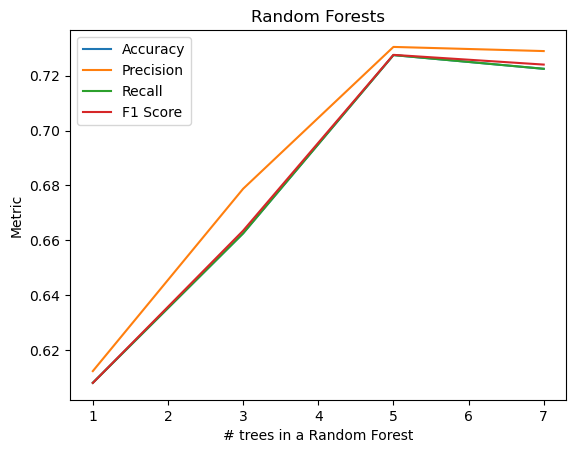

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(num_trees, accu_list)
plt.plot(num_trees, prec_list)
plt.plot(num_trees, recall_list)
plt.plot(num_trees, f1_list)
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.xlabel('# trees in a Random Forest')
plt.ylabel('Metric')
plt.title('Random Forests')
plt.show()

### AdaBoost

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import warnings

/tmp/ipykernel_26184/2940144087.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [27]:
data = np.genfromtxt('PCA_MNIST.csv',delimiter=',')

In [28]:
X_data = (data[1:,1:]+255.0)/255.0 
Y_data = data[1:,0]
train_size = int(0.8 * len(X_data))
X_train = X_data[:train_size,:]
y_train = Y_data[:train_size].reshape(-1)
X_test = X_data[train_size:,:]
y_test = Y_data[train_size:].reshape(-1)

AdaBoost is implemented using three different types of base classifiers.  
    -Decision Trees with max_depth = 1.  
    -SVM with linear kernel and c = 0.1.  
    -MLP with hidden sizes of (10, 5).  

Each with varying number of estimators.

--------------------------BASE ESTIMATOR IS DecisionTreeClassifier(max_depth=1)---------------------------------


<Figure size 640x480 with 0 Axes>

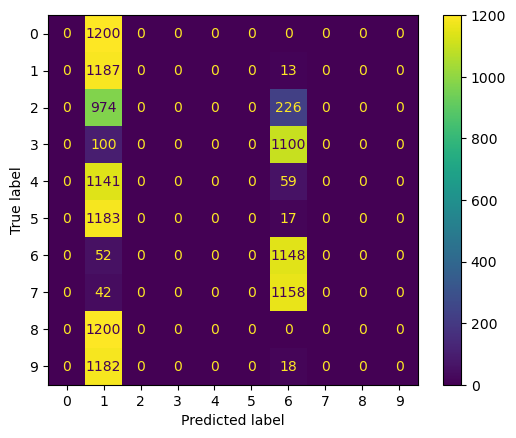

<Figure size 640x480 with 0 Axes>

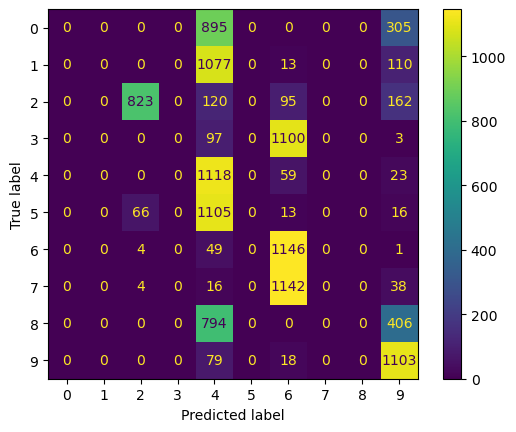

<Figure size 640x480 with 0 Axes>

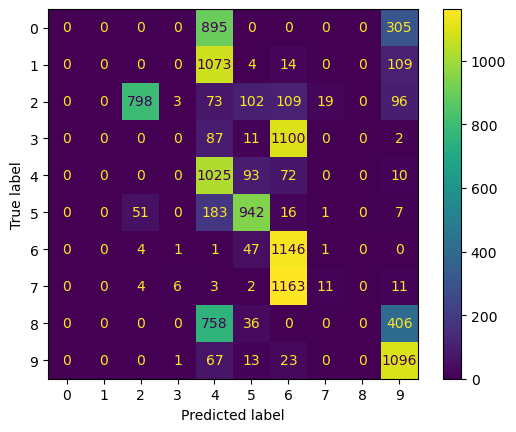

<Figure size 640x480 with 0 Axes>

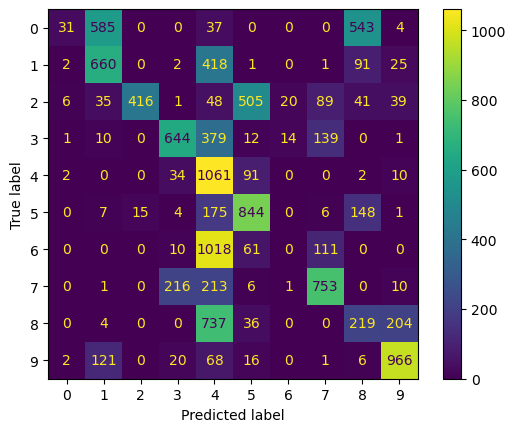

<Figure size 640x480 with 0 Axes>

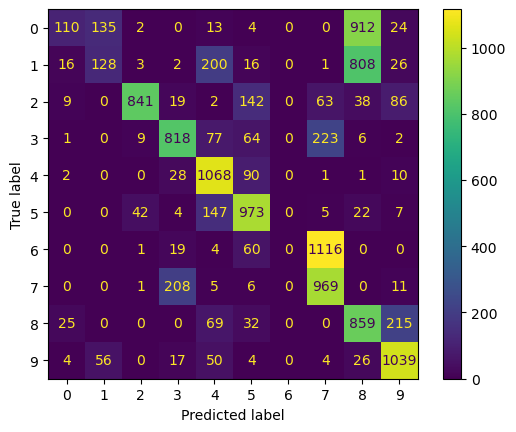

<Figure size 640x480 with 0 Axes>

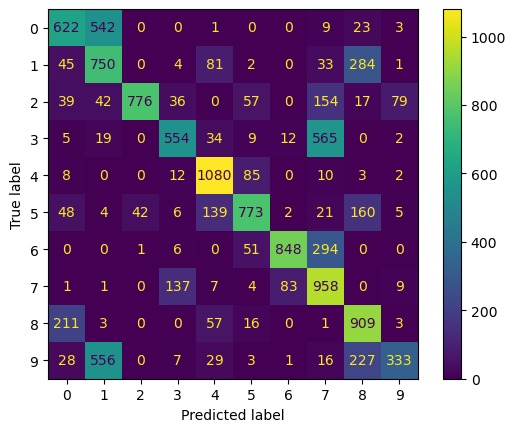

In [29]:

warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier(max_depth=1)
svm = SVC(kernel='linear', C=0.1, probability=True)
# mlp = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=100,  activation='relu', solver='adam', random_state=None)
base_estimator = tree
print(f'--------------------------BASE ESTIMATOR IS {base_estimator}---------------------------------')
# Change the base estimator and check.
boosted_clf = AdaBoostClassifier(base_estimator=base_estimator, learning_rate=1.0, algorithm='SAMME')

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []
conf_matrices = []
train_errors = []
n_learners = []

for n in range(1, 31, 5):
    boosted_clf.set_params(n_estimators=n)
    boosted_clf.fit(X_train, y_train)
    y_pred_train = boosted_clf.predict(X_train)
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    train_errors.append(train_error)
    n_learners.append(n)
    
    y_pred = boosted_clf.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    prec_scores.append(precision_score(y_test, y_pred, average='weighted'))
    rec_scores.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    plt.figure()
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    disp.plot()
    plt.show()

In [30]:

print(f'num_estimators: {n_learners} | Accuracy: {acc_scores} | Precision: {prec_scores} | Recall: {rec_scores} | F1 Scores: {f1_scores}')

num_estimators: [1, 6, 11, 16, 21, 26] | Accuracy: [0.19458333333333333, 0.3491666666666667, 0.4181666666666667, 0.4661666666666667, 0.5670833333333334, 0.6335833333333334] | Precision: [0.04507211712400194, 0.19550494946745076, 0.3125908228247727, 0.5277376538304283, 0.5541733669610621, 0.6896062650402958] | Recall: [0.19458333333333333, 0.3491666666666667, 0.4181666666666667, 0.4661666666666667, 0.5670833333333334, 0.6335833333333334] | F1 Scores: [0.07157962808455312, 0.22603843368662183, 0.3094216417300925, 0.4307708283720258, 0.5119864882575956, 0.6331660268777439]


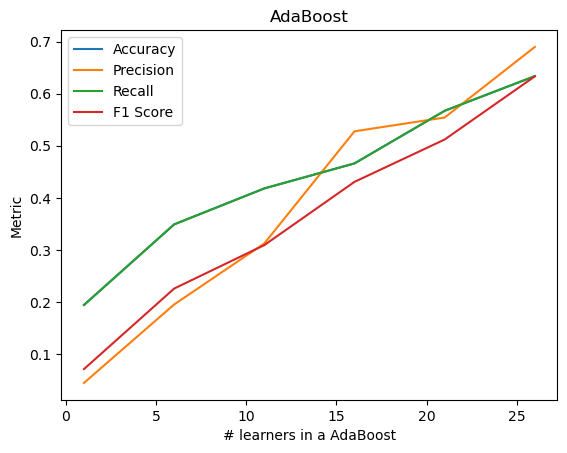

In [34]:

plt.figure()
plt.plot(n_learners, acc_scores)
plt.plot(n_learners, prec_scores)
plt.plot(n_learners, rec_scores)
plt.plot(n_learners, f1_scores)
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
plt.xlabel('# learners in a AdaBoost')
plt.ylabel('Metric')
plt.title('AdaBoost')
plt.show()

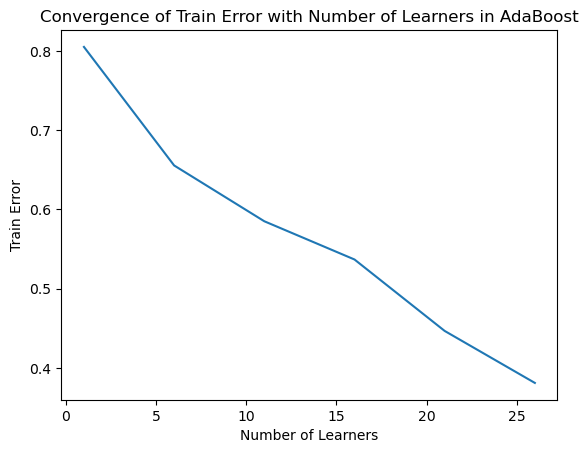

In [32]:
plt.plot(n_learners, train_errors)
plt.title('Convergence of Train Error with Number of Learners in AdaBoost')
plt.xlabel('Number of Learners')
plt.ylabel('Train Error')
plt.show()